In [52]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import zlib, base64
from scipy import signal
import os
import shutil
import json
from pathlib import Path
from tqdm import tqdm

# Do perspective transform on the original images

In [34]:
import segmentation_CNN_beta.seg_cnn as seg

In [48]:
root = Path(os.path.expanduser('~/Codes/ResearchProjects/Solar_Cell_Cracks/PVEL/'))
raw_im_dir = root/'raw_images/ALT_EL_Images/merge'
transform_ann_dir = root/'perspective_transformed/masks_ATL_no_bg/merge/'

ann_paths = os.listdir(transform_ann_dir)
if '.DS_Store' in ann_paths:
    ann_paths.remove('.DS_Store')

## #operation on one example

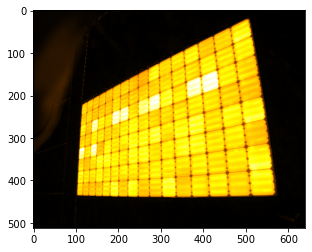

In [42]:
path = ann_paths[1]
name = path.split('.')[0]

image = cv.imread(str(raw_im_dir/(name+'.png')))
plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))

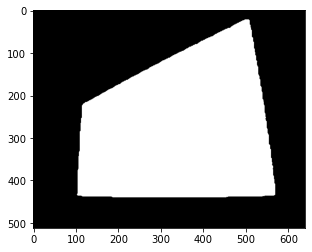

In [43]:
mask, mask_center = seg.load_mask(transform_ann_dir/path, image)
plt.imshow(mask, "gray")

In [44]:
corners = seg.find_module_corner(mask,mask_center,method=1,displace=3, corner_center=True, center_displace=70)
corners

array([[112.11458498, 214.41109848],
       [512.98132188,  12.95834814],
       [ 99.55349601, 440.26718572],
       [574.31701582, 440.23967182]])

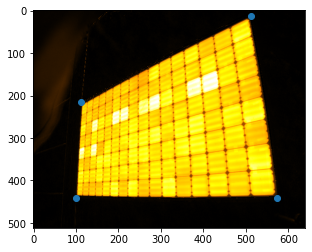

In [45]:
xs, ys = list(zip(*corners))
plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
plt.scatter(xs,ys)

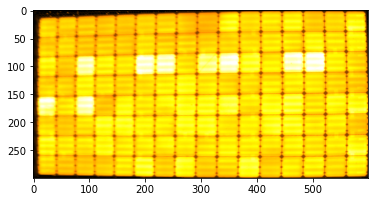

In [46]:
wrap = seg.perspective_transform(image, corners, 600, 300)
plt.imshow(cv.cvtColor(wrap, cv.COLOR_BGR2RGB))

## #operation on all the solar modules

In [53]:
store_dir = Path('./perspective_transformed')
err_dir = Path('./errors')

In [58]:
N = 0
N_err = 0
for file in tqdm(ann_paths):
    N += 1
    try:
        name = file.split('.')[0]
        path = transform_ann_dir/file
        image = cv.imread(str(raw_im_dir/(name+'.png')))

        mask, mask_center = seg.load_mask(path, image)
        corners = seg.find_module_corner(mask, mask_center, method=0,displace=3)
        wrap = seg.perspective_transform(image, corners, 600, 300)
        peak_x, peak_y = seg.find_cell_corner(wrap)
        if len(peak_x) > 12 and len(peak_y) > 5:
            cv.imwrite(str(store_dir/(name+'.png')), wrap)
        else:
            #print(name + " trying method2")
            corners = seg.find_module_corner(mask, mask_center, method=1,displace=3)
            wrap = seg.perspective_transform(image, corners, 600, 300)
            peak_x, peak_y = seg.find_cell_corner(wrap)
            if len(peak_x) > 12 and len(peak_y) > 5:
                cv.imwrite(str(store_dir/(name+'.png')), wrap)
            else: 
                corners = seg.find_module_corner(mask, mask_center, method=0,displace=3,corner_center=True,center_displace=50)
                wrap = seg.perspective_transform(image, corners, 600, 300)
                peak_x, peak_y = seg.find_cell_corner(wrap)
                if len(peak_x) > 12 and len(peak_y) > 5:
                    cv.imwrite(str(store_dir/(name+'.png')), wrap)
                else:
                    corners = seg.find_module_corner(mask, mask_center, method=1,displace=3,corner_center=True,center_displace=50)
                    wrap = seg.perspective_transform(image, corners, 600, 300)
                    peak_x, peak_y = seg.find_cell_corner(wrap)
                    if len(peak_x) > 12 and len(peak_y) > 5:
                        cv.imwrite(str(store_dir/(name+'.png')), wrap)
                    else:
                        N_err+=1
                        #print(name+" seg error")
                        #with open("error2.csv",'a') as f:
                        #    f.write(name+'.png\n')
                        shutil.copyfile(raw_im_dir/(name+'.png'), err_dir/(name+'.png'))
        
    except:
            #print(name+" run error")
        N_err += 1
        #with open("error2.csv",'a') as f:
        #    f.write(name+'.png\n')
        shutil.copyfile(raw_im_dir/(name+'.png'), err_dir/(name+'.png'))

print("total images: "+str(N))
print("failed images:"+ str(N_err))
print("accuracy: " + str(1-N_err/N))

100%|██████████| 120/120 [00:03<00:00, 32.18it/s]total images: 120
failed images:28
accuracy: 0.7666666666666666



# Classify the modules with object detection

In [62]:
from defective_cell_detection.module_classify import count_defects
from defective_cell_detection.visualize import draw_rec

In [61]:
detection_ann_dir = root/'prediction_detection/prediction_ATL/transformed/ann'
transformed_im_dir = root/'perspective_transformed/masks_ATL_no_bg/transformed/'

detect_ann_paths = os.listdir(detection_ann_dir)

In [63]:
color = {
    'crack_bbox_yolo': (60, 124, 90), # green
    'solder_bbox_yolo': (190, 112, 78), # blue
    'oxygen_bbox_yolo': (40, 64, 183), # red
    'intra_bbox_yolo': (103, 52, 154) # purple
}

In [64]:
folder = Path('processed_images')
for subfolder in ['category1', 'category2', 'category3']:
    os.makedirs(folder/subfolder, exist_ok=True)

In [65]:
for file in tqdm(detect_ann_paths):
    
    name = file.split('.')[0]
    image = cv.imread(str(transformed_im_dir/(name+'.png')))

    crack, oxygen, intra, solder = count_defects(detection_ann_dir/file)
    
    draw_rec(detection_ann_dir/file, image, color, 3)

    if crack <= 1 and oxygen == 0 and solder == 0 and intra == 0:
        with open("classification.csv",'a') as f2:
            f2.write(name+',category1\n')
        
        cv.imwrite('./processed_images/category1/'+name+'.png', image)

    elif (crack > 1 or oxygen > 0 or solder > 0) and intra == 0:
        with open("classification.csv",'a') as f2:
            f2.write(name+',category2\n')

        cv.imwrite('./processed_images/category2/'+name+'.png', image)

    elif intra > 0:
        with open("classification.csv",'a') as f2:
            f2.write(name+',category3\n')
        
        cv.imwrite('./processed_images/category3/'+name+'.png', image)

100%|██████████| 92/92 [00:01<00:00, 86.49it/s]
